In [125]:
import numpy as np

import matplotlib.pyplot as plt


from scipy.signal import savgol_filter, find_peaks,lfilter
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from scipy.interpolate import interp1d






In [343]:
# --------- File loading and preprocessing ---------

# Path to filtered respiration data files and list of bad channels
filename = r"C:\Users\emir.ege-nemutlu\Desktop\resp\Clinical\interpcsv\interpSigCHU1020.csv"

# Load the filtered signal from CSV and transpose it

df = pd.read_csv(filename, sep=',')

start = int(10*1000)
stop = int(50*1000)
df = df.T[start:stop] #Rows become channels, columns become time samples 
# List of bad leads (channels to exclude from analysis)
# Badlead_Ve = [1,15,	16,	25,	46,	53,	71,	72,	74,	78,	84,	96,	97, 105, 152, 153,]

In [344]:

# Remove bad leads from the dataframe
# df.drop(Badlead_Ve, axis=1, inplace=True)
freq = 1000
# Create a time vector assuming a sampling rate of 2048 Hz
time = np.linspace(0, df[1].size / freq, df[1].size)




In [345]:
# time = time[1:]

a = pd.DataFrame(df.to_numpy()[:,:])
# h = [0.1, 0.2, 0.0, -0.2, -0.1]
# H = np.array(h)
# Y_filtered = np.apply_along_axis(lambda row: lfilter(H, 1.0, row), axis=1, arr=a)
# thresholdpercent = 0.6
# windowsize = int(0.150*2048)
# # Step 2: Square the filtered signal
# Y_squared = Y_filtered ** 2

# # Step 3: Moving average (via convolution), applied row-wise
# kernel = np.ones(windowsize) / windowsize
# a = np.apply_along_axis(lambda row: np.convolve(row, kernel, mode='same'), axis=0, arr=Y_squared)

print(time.shape)
print(a)
# a = a.T

(40000,)
            0         1         2         3         4         5         6    \
0      0.098772  0.080104  0.021412  0.067534  0.091065  0.069182  0.070483   
1      0.105856  0.086046  0.022609  0.071636  0.098431  0.077232  0.076041   
2      0.112399  0.090745  0.023502  0.075772  0.105530  0.085495  0.083107   
3      0.115708  0.091859  0.023240  0.075867  0.108776  0.090085  0.086064   
4      0.118399  0.092565  0.022866  0.075583  0.111731  0.093453  0.088112   
...         ...       ...       ...       ...       ...       ...       ...   
39995 -0.368440 -0.247661 -0.078582 -0.296778 -0.325815 -0.277053 -0.218635   
39996 -0.339514 -0.219176 -0.069013 -0.264071 -0.296163 -0.249666 -0.191587   
39997 -0.298066 -0.182947 -0.056885 -0.221239 -0.257025 -0.214053 -0.158406   
39998 -0.260881 -0.150483 -0.045861 -0.182138 -0.222455 -0.182142 -0.128894   
39999 -0.218216 -0.112798 -0.033600 -0.139849 -0.182782 -0.146714 -0.096710   

            7         8         9    ...  

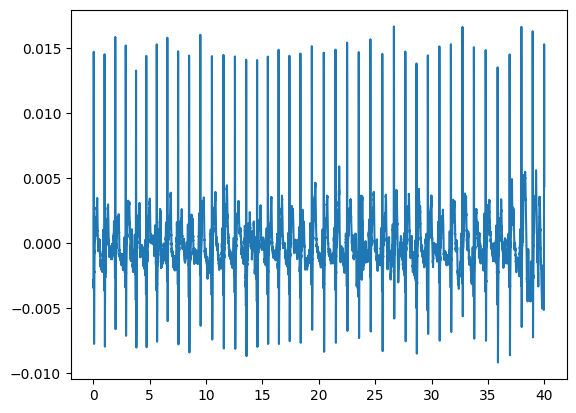

In [356]:
# Select channel number 2 (e.g., one ECG lead) from the dataframe
n_ecg = 8

x = df[n_ecg].copy()  # Make a copy of the signal for processing

# Define parameters for peak detection
min_distance_qrs_ms = 350  # Minimum time between two QRS complexes (in ms)
sampling_rate = freq       # Sampling rate in Hz

plt.figure()


plt.plot(time,x)

plt.show()

first high_peaks removed
33
40


C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_9588\2126955292.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[time_low_peaks],x[time_low_peaks])
C:\Users\emir.ege-nemutlu\AppData\Local\Temp\ipykernel_9588\2126955292.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(time[time_high_peaks],x[time_high_peaks])


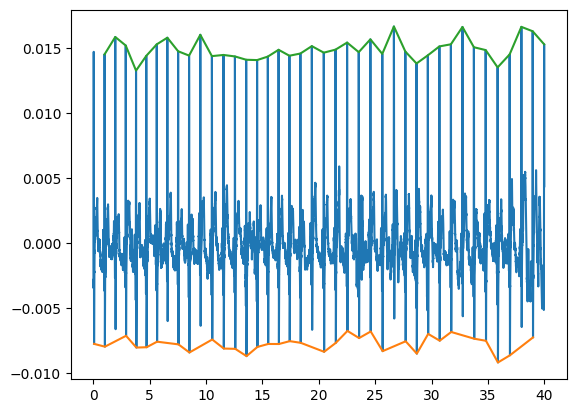

In [357]:

# Detect negative peaks (likely R-troughs in ECG) with minimum prominence and spacing
time_low_peaks, _ = find_peaks(
    -x, 
    

    distance= (min_distance_qrs_ms / 1000) * sampling_rate,
    height=0.4 * np.max(x)  # seuil minimum en valeur absolue
)

# Detect positive peaks (likely R-peaks in ECG)
time_high_peaks, _ = find_peaks(
    x, 

    distance=min_distance_qrs_ms / 1000 * sampling_rate,
    height=0.4 * np.max(x)  # seuil minimum en valeur absolue
)

# # Ensure the signal starts with a low peak (trough)
if time_low_peaks[0] > time_high_peaks[0]:  
    time_high_peaks = time_high_peaks[1:]  # Remove first high peak if it occurs before the first trough
    print("first high_peaks removed")

# Ensure the signal ends with a high peak
if time_low_peaks[-1] > time_high_peaks[-1]:
    print("last low_peaks removed")
    time_low_peaks = time_low_peaks[:-1]  # Remove last low peak if it occurs after the last high peak

# Debug: print number of detected peaks
print(len(time_low_peaks))
print(len(time_high_peaks))


plt.figure()


plt.plot(time,x)
plt.plot(time[time_low_peaks],x[time_low_peaks])
plt.plot(time[time_high_peaks],x[time_high_peaks])

plt.show()

In [358]:
# Define the number of points corresponding to a 60ms window
# 50 samples at 2048 Hz ≈ 50 milliseconds
nPoint50ms = int(50 * freq / 1000)

# Assign the signal dataframe to a new variable
signals = df[6:]

# Ensure that rows are channels and columns are time samples
if signals.shape[1] < signals.shape[0]:
    signals = signals.T

# Convert the DataFrame to a NumPy array of floats for numerical operations
signals = signals.to_numpy(dtype=float)

# Initialize matrix to store RR amplitudes:
# Shape = (60 channels × number of R-peaks)
RRAmplitude = np.zeros((df.shape[1], len(time_high_peaks)))

# Initialize a placeholder vector for PCA projection (3D)
vector = np.zeros((3, len(time_high_peaks)))

# Restrict the signal matrix to the first 60 channels
signals = signals[:df.shape[1], :]

# Loop through each detected R-peak (time_high_peaks)
for iPeak, localPeak in enumerate(time_high_peaks):
    
    # For each channel, get the max absolute value in a ±60ms window around the peak
    localMax = [
         np.abs((sig[max(localPeak - nPoint50ms,0) : min(localPeak + nPoint50ms,len(sig))]).max() )#has my fix
        for sig in signals
    ]
    
    # Store the amplitudes in the corresponding column
    RRAmplitude[:, iPeak] = localMax[0:df.shape[1]]

# Create a processing pipeline:
# 1. Standardize features across channels
# 2. Apply PCA to reduce to 3 components
pca = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=3))
])

# Fit PCA on the transposed RRAmplitude (features in columns) and transform the data
pca_RRamp = pca.fit_transform(RRAmplitude.T)

(-1.0, 1.0)

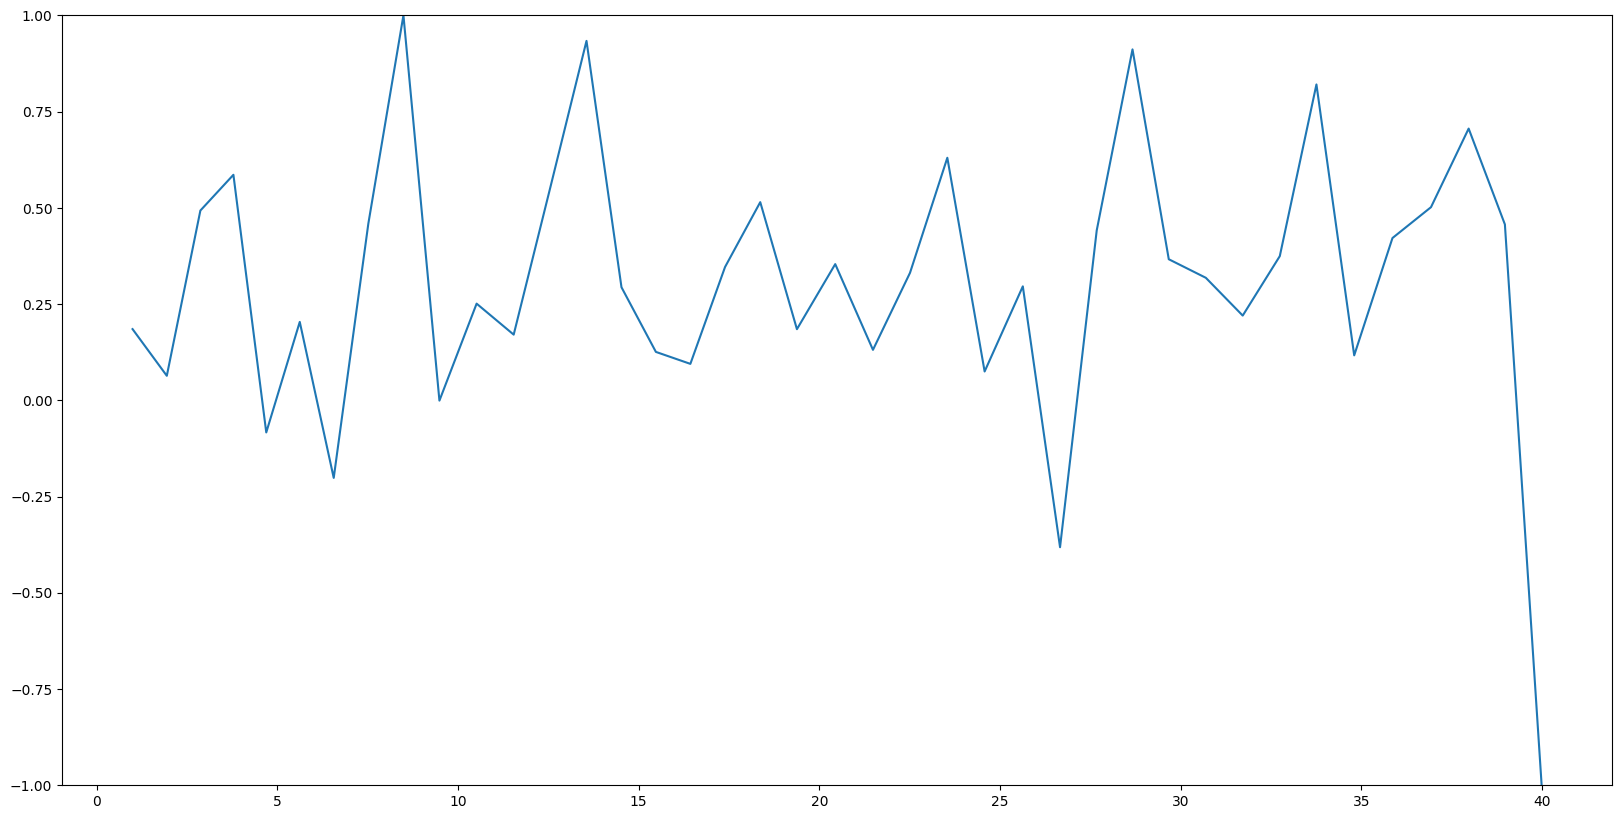

In [359]:
# Select which PCA component to use (e.g., 0 = first principal component)
n_component = 0

# Normalize the selected PCA component to the range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
pca_RRamp_normalized = scaler.fit_transform(
    pca_RRamp[:, n_component].reshape(-1, 1)  # Reshape to 2D for scaler
).flatten()  # Flatten back to 1D after scaling

# Create a large figure and plotting axis
ax = plt.figure(figsize=[20, 10]).subplots()

# Plot the normalized PCA projection against the time of R-peaks
ax.plot(time[time_high_peaks], pca_RRamp_normalized)

# Set Y-axis limits to match the normalization range
ax.set_ylim([-1, 1])


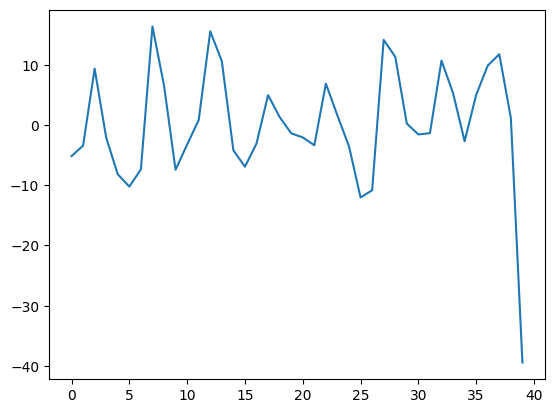

In [360]:
reference_track = savgol_filter(pca_RRamp[:,n_component], window_length=4, polyorder=2)
plt.plot(reference_track)

In [361]:
# Create time vector corresponding to PCA values (at each R-peak)
time_reference = time[time_high_peaks]

# Create an interpolation function to reconstruct a continuous signal
interp_func = interp1d(
    time_reference,         # Known time points (where PCA was computed)
    reference_track,        # Corresponding PCA values
    kind='linear',          # Interpolation type: 'linear' 
    fill_value="extrapolate"  # Allow extrapolation beyond the last known time point
)

# Use the original time vector at full sampling rate (2048 Hz)
time_full = time  # Already defined earlier using np.linspace(...)

# Interpolate (resample) the PCA signal at the full resolution of the original signal
reference_resampled = interp_func(time_full)

In [362]:
def select_peaks_near_extreme_amplitude(part, time_high_peaks, amplitude_percent=0.2):
    """
    Identify R-peaks that fall within ±20% of the amplitude near respiratory peaks and troughs.

    Parameters:
        part: 1D numpy array
            The respiratory signal (e.g., PCA-resampled respiration).
        time_high_peaks: list or array
            Indices of R-peaks to classify.
        amplitude_percent: float
            The proportion of the peak-to-trough amplitude to define the zone (default = 20%).

    Returns:
        df_top: DataFrame of R-peaks near the top 20% amplitude
        df_bottom: DataFrame of R-peaks near the bottom 20% amplitude
        df_outside: DataFrame of R-peaks outside the 20% amplitude zones
    """

    # Normalize the respiratory signal to [0, 1] range
    scaler = MinMaxScaler()
    resp_norm = scaler.fit_transform(part.reshape(-1, 1)).flatten()

    # Detect peaks (maxima) and troughs (minima) in the respiration
    peaks, _ = find_peaks(resp_norm, prominence=0.3, distance=500)
    troughs, _ = find_peaks(-resp_norm, prominence=0.3, distance=500)

    # Lists to collect R-peaks
    rpeaks_top = []
    rpeaks_bottom = []
    rpeaks_outside = []

    # Plot the normalized respiratory signal
    plt.figure(figsize=(20, 6))
    plt.plot(resp_norm, label="Normalized Respiration")
    plt.scatter(peaks, resp_norm[peaks], c='red', label='Peaks')
    plt.scatter(troughs, resp_norm[troughs], c='blue', label='Troughs')

    for rpeak in time_high_peaks:
        if len(peaks) == 0 or len(troughs) == 0:
            continue

        # Find closest peak and trough
        closest_peak = peaks[np.argmin(np.abs(peaks - rpeak))]
        closest_trough = troughs[np.argmin(np.abs(troughs - rpeak))]

        # Determine local amplitude range
        amp = resp_norm[closest_peak] - resp_norm[closest_trough]

        if abs(closest_peak - rpeak) < abs(closest_trough - rpeak):
            # Closer to peak → top zone
            threshold = resp_norm[closest_peak] - amplitude_percent * amp
            if resp_norm[rpeak] >= threshold:
                rpeaks_top.append(rpeak)
                plt.axhspan(threshold, 1, xmin=rpeak/len(resp_norm), xmax=(rpeak+1)/len(resp_norm),
                            color='green', alpha=0.2, label='Top ±20% amp' if len(rpeaks_top) == 1 else "")
            else:
                rpeaks_outside.append(rpeak)
        else:
            # Closer to trough → bottom zone
            threshold = resp_norm[closest_trough] + amplitude_percent * amp
            if resp_norm[rpeak] <= threshold:
                rpeaks_bottom.append(rpeak)
                plt.axhspan(0, threshold, xmin=rpeak/len(resp_norm), xmax=(rpeak+1)/len(resp_norm),
                            color='purple', alpha=0.2, label='Bottom ±20% amp' if len(rpeaks_bottom) == 1 else "")
            else:
                rpeaks_outside.append(rpeak)

    # Plot classified R-peaks
    plt.scatter(rpeaks_top, resp_norm[rpeaks_top], c='darkgreen', label='R-peaks top 20% amplitude')
    plt.scatter(rpeaks_bottom, resp_norm[rpeaks_bottom], c='indigo', label='R-peaks bottom 20% amplitude')
    plt.scatter(rpeaks_outside, resp_norm[rpeaks_outside], c='r', label='R-peaks outside 20% zones')

    plt.title("R-peaks within ±20% amplitude zones near respiratory extremes")
    plt.legend()
    plt.grid(True)
    plt.show()

    df_top = pd.DataFrame(sorted(set(rpeaks_top)), columns=['rpeaks_top_20_amp'])
    df_bottom = pd.DataFrame(sorted(set(rpeaks_bottom)), columns=['rpeaks_bottom_20_amp'])
    df_outside = pd.DataFrame(sorted(set(rpeaks_outside)), columns=['rpeaks_outside'])

    return df_top, df_bottom, df_outside


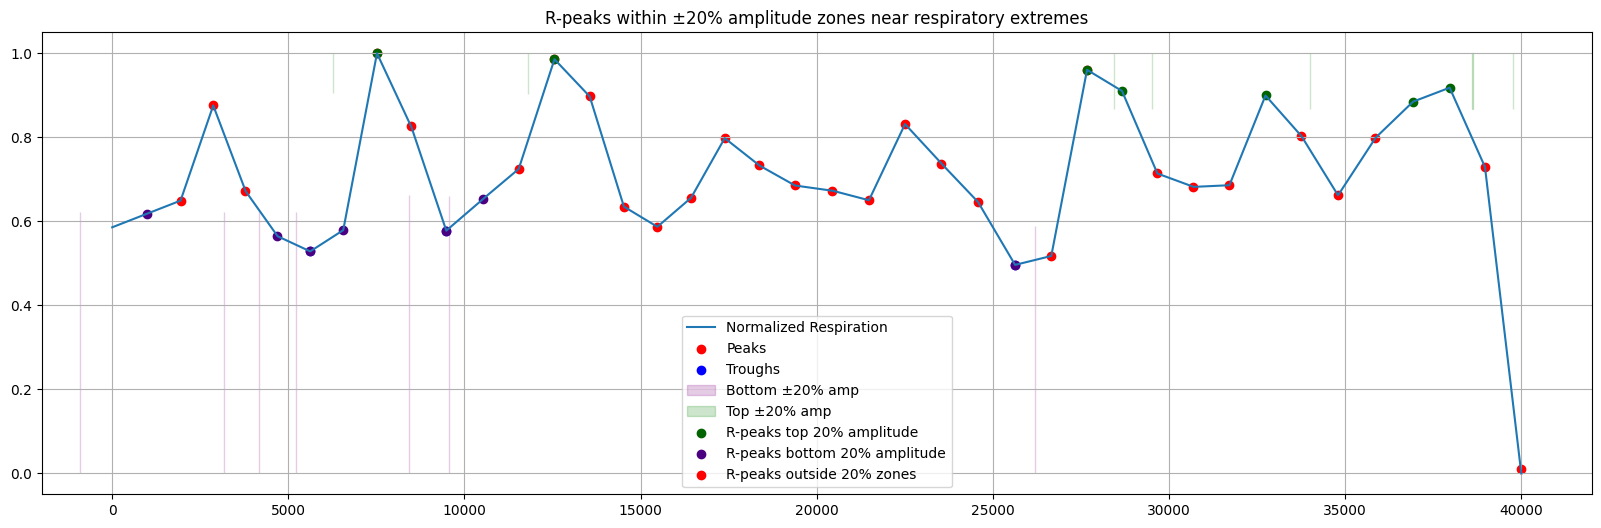

In [363]:
df_top, df_bottom, df_outside = select_peaks_near_extreme_amplitude(reference_resampled, time_high_peaks, 0.20)

In [187]:
print(df_bottom)

Empty DataFrame
Columns: [rpeaks_bottom_20_amp]
Index: []
